# Balance de clases con SMOTE

In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.metrics import geometric_mean_score

In [2]:
df = pd.read_excel('df_objetivo/df_escalado.xlsx')

In [3]:
# Separar variables predictoras (X) y variable objetivo (y)
X = df.drop("RIESGO_DESERCION", axis=1)
y = df["RIESGO_DESERCION"]

# Dividir antes del sobremuestreo para evitar fuga de datos (data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Aplicar SMOTE SOLO en los datos de entrenamiento
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Mostrar nueva distribución
import pandas as pd
print("Distribución antes de SMOTE:")
print(pd.Series(y_train).value_counts())
print("\nDistribución después de SMOTE:")
print(pd.Series(y_train_sm).value_counts())

Distribución antes de SMOTE:
0    766
1    132
Name: RIESGO_DESERCION, dtype: int64

Distribución después de SMOTE:
0    766
1    766
Name: RIESGO_DESERCION, dtype: int64


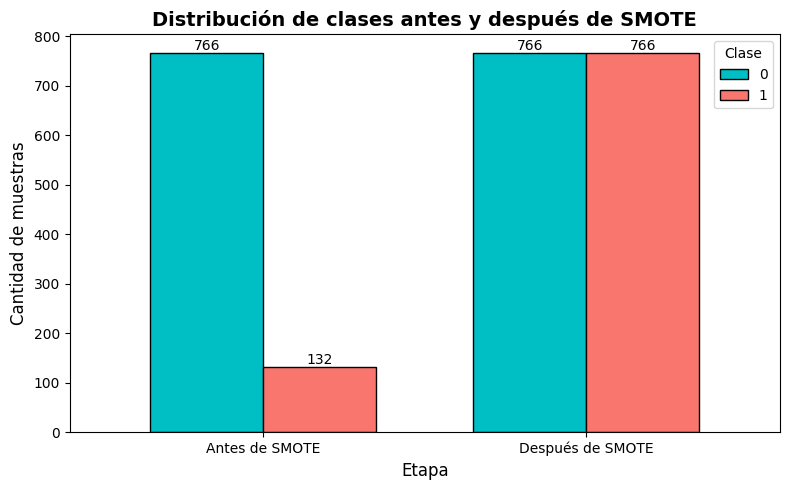

In [4]:
# Crear DataFrame con las distribuciones
distribucion = pd.DataFrame({
    'Antes de SMOTE': pd.Series(y_train).value_counts(),
    'Después de SMOTE': pd.Series(y_train_sm).value_counts()
}).T

# Estilo de colores
palette = ["#00BFC4", "#F8766D"]

# Crear gráfico
fig, ax = plt.subplots(figsize=(8, 5))
bars = distribucion.plot(kind='bar', stacked=False, color=palette, ax=ax, width=0.7, edgecolor='black')

# Personalización
ax.set_title('Distribución de clases antes y después de SMOTE', fontsize=14, fontweight='bold')
ax.set_xlabel('Etapa', fontsize=12)
ax.set_ylabel('Cantidad de muestras', fontsize=12)
ax.legend(title='Clase', labels=['0', '1'])
ax.tick_params(axis='x', labelrotation=0)

# Agregar etiquetas sobre cada barra
for container in bars.containers:
    bars.bar_label(container, label_type='edge', fontsize=10, color='black', padding=0)

# Ajustar y mostrar
plt.tight_layout()
plt.show()


# Modelos de machine learning

### Sin ajuste de hiperparámetros

## Random forest

In [35]:
# Paso 1: Definir el modelo con hiperparámetros base
rf_model = RandomForestClassifier(
    n_estimators=20,           # Número de árboles
    max_depth=None,             # Sin límite de profundidad (los árboles crecen hasta puro criterio de partición)
    min_samples_split=2,        # Por defecto
    min_samples_leaf=1,         # Por defecto
    max_features='sqrt',        # Raíz cuadrada del total de features
    class_weight=None,          # Sin balanceo adicional (porque ya apliqué SMOTE)
    random_state=42             # Para resultados reproducibles
)


# print(f"AUC promedio (CV): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Paso 2: Entrenar con datos balanceados
rf_model.fit(X_train_sm, y_train_sm)

# Paso 3: Predecir con los datos de prueba (sin balancear)
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilidad clase positiva


Reporte de clasificación:
               precision    recall  f1-score   support

           0     0.9675    0.9939    0.9805       329
           1     0.9574    0.8036    0.8738        56

    accuracy                         0.9662       385
   macro avg     0.9625    0.8987    0.9271       385
weighted avg     0.9660    0.9662    0.9650       385

AUC: 0.9484
Matriz de Confusión:
 [[327   2]
 [ 11  45]]
Media Geométrica: 0.8937


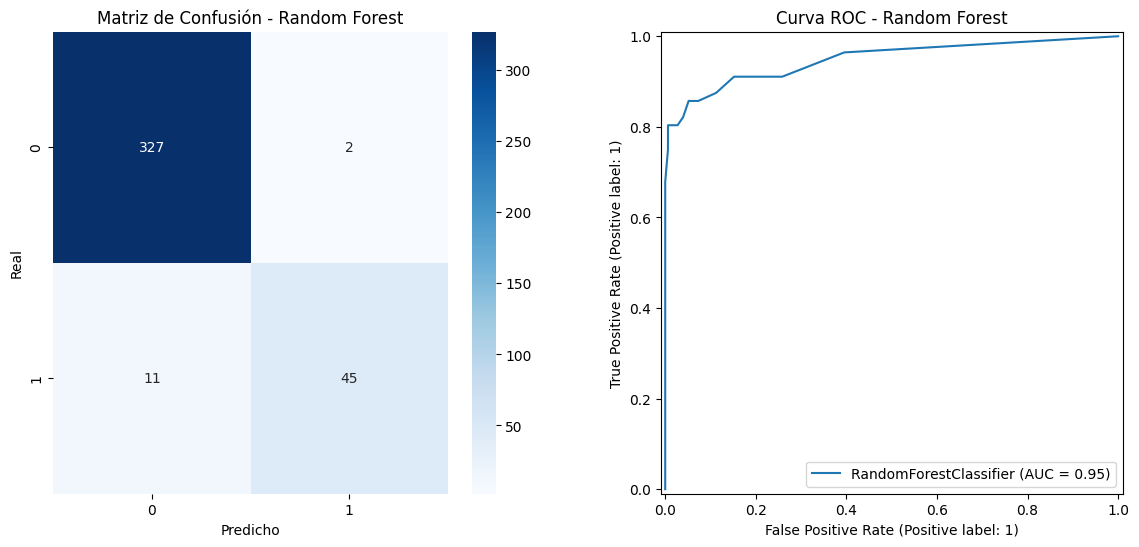

In [36]:
# Reporte de métricas
print("Reporte de clasificación:\n", classification_report(y_test, y_pred, digits=4))

# AUC
auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc:.4f}")


# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Imprimir la matriz de confusión en consola
print("Matriz de Confusión:\n", cm)

# Calcular la media geométrica
g_mean = geometric_mean_score(y_test, y_pred)
print(f"Media Geométrica: {g_mean:.4f}")

# Inicializar figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de Confusión - Random Forest")
axes[0].set_xlabel("Predicho")
axes[0].set_ylabel("Real")

# Subplot 2: Curva ROC
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=axes[1])
axes[1].set_title("Curva ROC - Random Forest")

# Ajustar diseño para evitar superposición
# plt.tight_layout()
plt.show()



C:\Users\andre\AppData\Local\Temp\ipykernel_2860\3937136900.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importancia", y="Variable", data=importancias_df.head(10), palette="viridis")


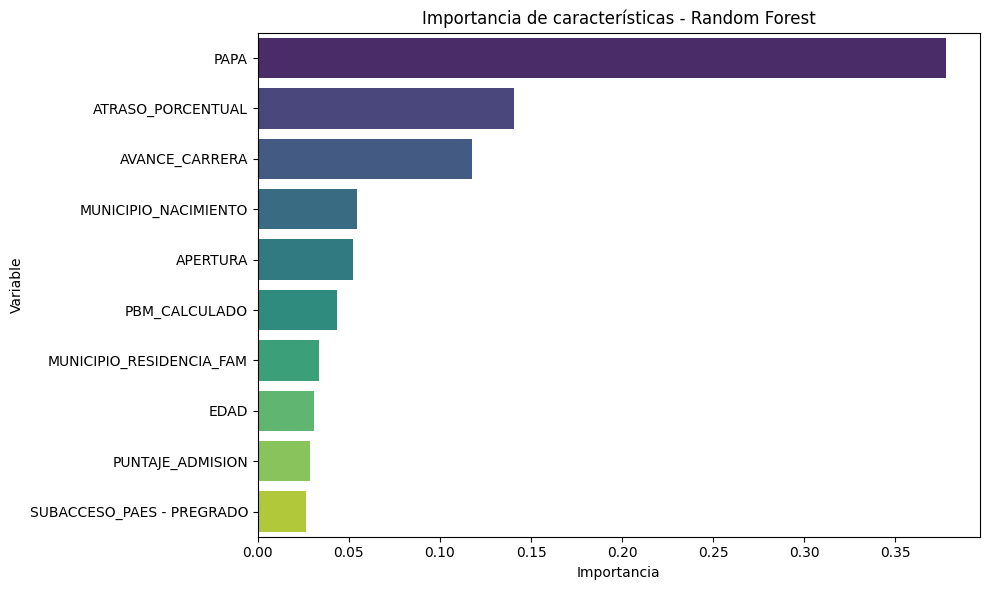

In [7]:
import pandas as pd
import numpy as np

importancias = rf_model.feature_importances_
nombres_vars = X_train_sm.columns  # Asegúrate que X_train_sm esté en DataFrame para obtener los nombres

# Mostrar las más importantes
importancias_df = pd.DataFrame({
    "Variable": nombres_vars,
    "Importancia": importancias
}).sort_values(by="Importancia", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importancia", y="Variable", data=importancias_df.head(10), palette="viridis")
plt.title("Importancia de características - Random Forest")
plt.tight_layout()
plt.show()


### Aplicar SHAP al modelo Random Forest

In [8]:
import shap
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

def diagnosticar_datos_shap(rf_model, X_train, X_test, y_train=None, y_test=None):
    """
    Función de diagnóstico para entender la estructura de tus datos
    y configurar SHAP correctamente
    """
    print("=== DIAGNÓSTICO DE DATOS PARA SHAP ===")
    print("-" * 50)
    
    # 1. Información básica del modelo
    print("1. INFORMACIÓN DEL MODELO:")
    print(f"   Tipo de modelo: {type(rf_model).__name__}")
    print(f"   Número de clases: {rf_model.n_classes_}")
    print(f"   Clases: {rf_model.classes_}")
    
    # 2. Información de los datos
    print(f"\n2. INFORMACIÓN DE LOS DATOS:")
    print(f"   Tipo de X_train: {type(X_train)}")
    print(f"   Forma de X_train: {X_train.shape}")
    print(f"   Tipo de X_test: {type(X_test)}")
    print(f"   Forma de X_test: {X_test.shape}")
    
    # 3. Nombres de características
    print(f"\n3. NOMBRES DE CARACTERÍSTICAS:")
    if hasattr(X_train, 'columns'):
        print(f"   DataFrame detectado")
        print(f"   Columnas: {list(X_train.columns)}")
        feature_names = X_train.columns.tolist()
    else:
        print(f"   Array numpy detectado")
        feature_names = [f'Feature_{i+1}' for i in range(X_train.shape[1])]
        print(f"   Nombres generados: {feature_names[:5]}{'...' if len(feature_names) > 5 else ''}")
    
    # 4. Información de las clases (si está disponible)
    if y_train is not None:
        print(f"\n4. INFORMACIÓN DE LAS CLASES:")
        unique_classes = np.unique(y_train)
        print(f"   Clases únicas en y_train: {unique_classes}")
        print(f"   Distribución de clases:")
        if hasattr(y_train, 'value_counts'):
            print(y_train.value_counts())
        else:
            unique, counts = np.unique(y_train, return_counts=True)
            for cls, count in zip(unique, counts):
                print(f"     Clase {cls}: {count} muestras")
    
    # 5. Probar SHAP
    print(f"\n5. PRUEBA DE SHAP:")
    try:
        explainer = shap.TreeExplainer(rf_model)
        print(f"   TreeExplainer creado exitosamente")
        
        # Usar una muestra pequeña para la prueba
        X_test_sample = X_test[:5] if len(X_test) > 5 else X_test
        shap_values = explainer.shap_values(X_test_sample)
        
        print(f"   Tipo de shap_values: {type(shap_values)}")
        
        if isinstance(shap_values, list):
            print(f"   Es una lista con {len(shap_values)} elementos (clases)")
            for i, sv in enumerate(shap_values):
                print(f"     Clase {i}: forma {sv.shape}")
        else:
            print(f"   Es un array con forma: {shap_values.shape}")
            
        # 6. Verificar compatibilidad de dimensiones
        print(f"\n6. VERIFICACIÓN DE DIMENSIONES:")
        if isinstance(shap_values, list):
            for i, sv in enumerate(shap_values):
                compatible = sv.shape[1] == X_test_sample.shape[1]
                print(f"   Clase {i}: SHAP {sv.shape} vs X_test {X_test_sample.shape} -> {'✓' if compatible else '✗'}")
                if not compatible:
                    if sv.shape[1] == X_test_sample.shape[1] + 1:
                        print(f"     -> Detectada columna extra (offset), se puede corregir")
        else:
            compatible = shap_values.shape[1] == X_test_sample.shape[1]
            print(f"   SHAP {shap_values.shape} vs X_test {X_test_sample.shape} -> {'✓' if compatible else '✗'}")
            
    except Exception as e:
        print(f"   Error al crear explainer: {e}")
        return None, None
    
    print("\n" + "=" * 50)
    print("DIAGNÓSTICO COMPLETADO")
    print("Copia y pega toda esta salida para obtener ayuda específica")
    print("=" * 50)
    
    return shap_values, feature_names

def crear_plot_shap_unico(rf_model, X_train, X_test, plot_type="bar", max_samples=100):
    """
    Crear UN SOLO plot de SHAP limpio
    
    Parameters:
    - plot_type: "bar" para importancia, "beeswarm" para distribución de valores
    - max_samples: número máximo de muestras a analizar (para velocidad)
    """
    print("=== CREANDO PLOT ÚNICO DE SHAP ===")
    
    # Preparar datos
    X_test_sample = X_test[:max_samples] if len(X_test) > max_samples else X_test
    
    # Obtener nombres de características
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns.tolist()
    else:
        feature_names = [f'Feature_{i+1}' for i in range(X_train.shape[1])]
    
    # Crear explainer y calcular valores SHAP
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test_sample)
    
    # Determinar qué valores SHAP usar
    if isinstance(shap_values, list):
        if len(shap_values) == 2:
            # Clasificación binaria - usar clase positiva
            shap_values_to_plot = shap_values[1]
            print(f"Clasificación binaria detectada, usando clase positiva")
        else:
            # Multiclase - usar primera clase por defecto
            shap_values_to_plot = shap_values[0]
            print(f"Clasificación multiclase, usando clase 0")
    else:
        shap_values_to_plot = shap_values
    
    # Ajustar dimensiones si es necesario
    if shap_values_to_plot.shape[1] != X_test_sample.shape[1]:
        if shap_values_to_plot.shape[1] == X_test_sample.shape[1] + 1:
            shap_values_to_plot = shap_values_to_plot[:, :-1]
            print("Dimensiones ajustadas (removida columna extra)")
    
    # Crear UN SOLO plot
    print(f"Creando {plot_type} plot...")
    if plot_type == "bar":
        shap.summary_plot(shap_values_to_plot, X_test_sample, 
                         feature_names=feature_names, 
                         plot_type="bar")
    else:
        shap.summary_plot(shap_values_to_plot, X_test_sample, 
                         feature_names=feature_names)
    
    print("Plot creado exitosamente!")
    return shap_values_to_plot

# =================================================================
# INSTRUCCIONES DE USO:
# # =================================================================
# print("INSTRUCCIONES:")
# print("1. Primero ejecuta el diagnóstico:")
# print("   shap_vals, nombres = diagnosticar_datos_shap(rf_model, X_train, X_test)")
# print()
# print("2. Luego crea UN SOLO plot:")
# print("   # Para plot de barras (importancia):")
# print("   crear_plot_shap_unico(rf_model, X_train, X_test, plot_type='bar')")
# print()
# print("   # Para plot de puntos (distribución):")
# print("   crear_plot_shap_unico(rf_model, X_train, X_test, plot_type='beeswarm')")
# print()
# print("3. Si tienes muchos datos, limita las muestras:")
# print("   crear_plot_shap_unico(rf_model, X_train, X_test, plot_type='bar', max_samples=50)")

In [9]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def crear_shap_plot_corregido(rf_model, X_train, X_test, plot_type="bar", max_samples=100, clase=1):
    """
    Crear UN SOLO plot de SHAP para tu caso específico
    
    Parameters:
    - rf_model: tu modelo Random Forest entrenado
    - X_train: datos de entrenamiento (DataFrame)
    - X_test: datos de prueba (DataFrame) 
    - plot_type: "bar" para importancia, "beeswarm" para distribución
    - max_samples: número máximo de muestras a analizar
    - clase: 0 para clase negativa, 1 para clase positiva (default=1)
    """
    
    print(f"=== CREANDO PLOT SHAP PARA CLASE {clase} ===")
    
    # Limitar muestras si es necesario
    if len(X_test) > max_samples:
        X_test_sample = X_test.iloc[:max_samples].copy()
        print(f"Usando {max_samples} muestras de {len(X_test)} disponibles")
    else:
        X_test_sample = X_test.copy()
        print(f"Usando todas las {len(X_test)} muestras")
    
    # Crear explainer y calcular valores SHAP
    print("Calculando valores SHAP...")
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test_sample)
    
    print(f"Forma original de shap_values: {shap_values.shape}")
    
    # Tu caso específico: (samples, features, classes)
    # Necesitamos extraer los valores para la clase específica
    if len(shap_values.shape) == 3:
        shap_values_clase = shap_values[:, :, clase]
        print(f"Extrayendo clase {clase}, nueva forma: {shap_values_clase.shape}")
    else:
        # Por si acaso el formato cambia
        shap_values_clase = shap_values
        print(f"Formato directo, forma: {shap_values_clase.shape}")
    
    # Obtener nombres de características
    feature_names = X_test_sample.columns.tolist()
    print(f"Características: {len(feature_names)} detectadas")
    
    # Verificar dimensiones finales
    print(f"Verificación final: SHAP {shap_values_clase.shape} vs X_test {X_test_sample.shape}")
    
    if shap_values_clase.shape[1] != X_test_sample.shape[1]:
        raise ValueError(f"Error de dimensiones: SHAP tiene {shap_values_clase.shape[1]} características, X_test tiene {X_test_sample.shape[1]}")
    
    # Crear el plot
    plt.figure(figsize=(10, 8))
    
    if plot_type == "bar":
        print("Creando summary plot tipo barra (importancia promedio)...")
        shap.summary_plot(shap_values_clase, X_test_sample, 
                         feature_names=feature_names, 
                         plot_type="bar",
                         show=False)
        plt.title(f'Importancia SHAP - Clase {clase} {"(Positiva)" if clase == 1 else "(Negativa)"}')
        
    elif plot_type == "beeswarm":
        print("Creando summary plot tipo beeswarm (distribución de valores)...")
        shap.summary_plot(shap_values_clase, X_test_sample, 
                         feature_names=feature_names,
                         show=False)
        plt.title(f'Distribución Valores SHAP - Clase {clase} {"(Positiva)" if clase == 1 else "(Negativa)"}')
    
    elif plot_type == "violin":
        print("Creando summary plot tipo violin...")
        shap.summary_plot(shap_values_clase, X_test_sample, 
                         feature_names=feature_names,
                         plot_type="violin",
                         show=False)
        plt.title(f'Distribución Violin SHAP - Clase {clase} {"(Positiva)" if clase == 1 else "(Negativa)"}')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Plot creado exitosamente para clase {clase}")
    
    return shap_values_clase

def crear_plots_comparativos(rf_model, X_train, X_test, max_samples=50, top_features=10):
    """
    Crear plots comparativos para ambas clases (lado a lado)
    """
    
    print("=== CREANDO PLOTS COMPARATIVOS ===")
    
    # Limitar muestras
    X_test_sample = X_test.iloc[:max_samples] if len(X_test) > max_samples else X_test
    
    # Calcular SHAP values
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test_sample)
    
    # Extraer valores para ambas clases
    shap_clase_0 = shap_values[:, :, 0]  # Clase negativa
    shap_clase_1 = shap_values[:, :, 1]  # Clase positiva
    
    feature_names = X_test_sample.columns.tolist()
    
    # Crear figura con subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot para clase 0 (negativa)
    plt.sca(ax1)
    shap.summary_plot(shap_clase_0, X_test_sample, 
                     feature_names=feature_names, 
                     plot_type="bar",
                     max_display=top_features,
                     show=False)
    ax1.set_title('Importancia SHAP - Clase 0 (Negativa)')
    
    # Plot para clase 1 (positiva)
    plt.sca(ax2)
    shap.summary_plot(shap_clase_1, X_test_sample, 
                     feature_names=feature_names, 
                     plot_type="bar",
                     max_display=top_features,
                     show=False)
    ax2.set_title('Importancia SHAP - Clase 1 (Positiva)')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Plots comparativos creados")
    
    return shap_clase_0, shap_clase_1

def mostrar_top_features(rf_model, X_train, X_test, max_samples=100, top_n=10):
    """
    Mostrar las características más importantes según SHAP
    """
    
    print(f"=== TOP {top_n} CARACTERÍSTICAS MÁS IMPORTANTES ===")
    
    X_test_sample = X_test.iloc[:max_samples] if len(X_test) > max_samples else X_test
    
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test_sample)
    
    # Para clase positiva (1)
    shap_clase_1 = shap_values[:, :, 1]
    
    # Calcular importancia promedio (valor absoluto)
    importancia_promedio = np.abs(shap_clase_1).mean(axis=0)
    
    # Crear DataFrame con resultados
    feature_names = X_test_sample.columns.tolist()
    df_importancia = pd.DataFrame({
        'Característica': feature_names,
        'Importancia_SHAP': importancia_promedio
    }).sort_values('Importancia_SHAP', ascending=False)
    
    print(f"\nTop {top_n} características para la clase POSITIVA:")
    print("-" * 60)
    for i, (idx, row) in enumerate(df_importancia.head(top_n).iterrows()):
        print(f"{i+1:2d}. {row['Característica']:35s} | {row['Importancia_SHAP']:.4f}")
    
    return df_importancia

# =================================================================
# CÓDIGO LISTO PARA USAR:
# =================================================================

# print("🎯 CÓDIGO OPTIMIZADO PARA TUS DATOS")
# print("=" * 60)
# print()
# print("1️⃣  CREAR PLOT PRINCIPAL (clase positiva - la que te interesa):")
# print("    shap_vals = crear_shap_plot_corregido(rf_model, X_train, X_test, plot_type='bar')")
# print()
# print("2️⃣  PARA VER DISTRIBUCIÓN DE VALORES:")
# print("    crear_shap_plot_corregido(rf_model, X_train, X_test, plot_type='beeswarm')")
# print()
# print("3️⃣  PARA COMPARAR AMBAS CLASES:")
# print("    crear_plots_comparativos(rf_model, X_train, X_test)")
# print()
# print("4️⃣  PARA VER RANKING DE CARACTERÍSTICAS:")
# print("    ranking = mostrar_top_features(rf_model, X_train, X_test)")
# print()
# print("💡 Si tienes muchos datos, usa max_samples para acelerar:")
# print("    crear_shap_plot_corregido(rf_model, X_train, X_test, max_samples=50)")

=== CREANDO PLOT SHAP PARA CLASE 1 ===
Usando 100 muestras de 385 disponibles
Calculando valores SHAP...
Forma original de shap_values: (100, 27, 2)
Extrayendo clase 1, nueva forma: (100, 27)
Características: 27 detectadas
Verificación final: SHAP (100, 27) vs X_test (100, 27)
Creando summary plot tipo beeswarm (distribución de valores)...


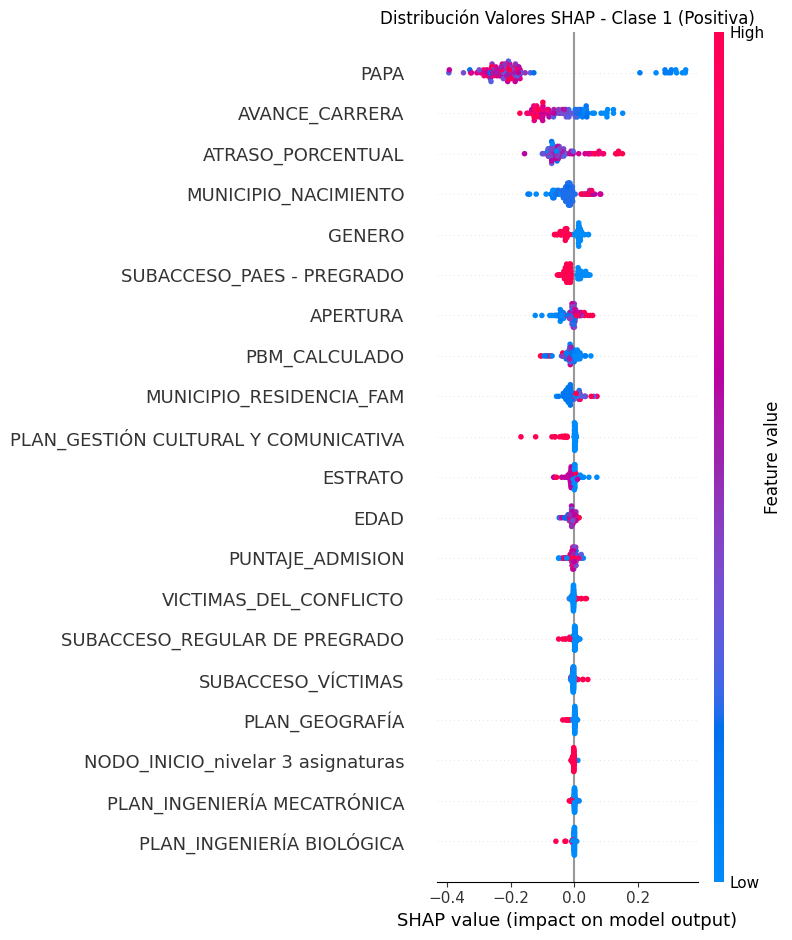

✓ Plot creado exitosamente para clase 1


array([[ 0.03919312,  0.00436437, -0.05907539, ..., -0.00115914,
        -0.00246384,  0.        ],
       [ 0.03499975,  0.01424017,  0.02028877, ...,  0.00018512,
        -0.0015255 ,  0.        ],
       [-0.14914214, -0.02370887,  0.015848  , ...,  0.00196906,
        -0.00428008,  0.        ],
       ...,
       [-0.09723877, -0.01429793,  0.01769848, ...,  0.00024702,
        -0.00147219,  0.        ],
       [-0.01681624, -0.0053034 , -0.03061697, ...,  0.00030309,
        -0.00336272,  0.        ],
       [-0.02632471,  0.00971992,  0.00040718, ...,  0.00016735,
        -0.00118758,  0.        ]])

In [10]:
crear_shap_plot_corregido(rf_model, X_train, X_test, plot_type='beeswarm')

### RF optimizado con GridSearch

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores hiperparámetros encontrados: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       329
           1       0.98      0.77      0.86        56

    accuracy                           0.96       385
   macro avg       0.97      0.88      0.92       385
weighted avg       0.96      0.96      0.96       385

AUC: 0.9540273556231003
Media Geométrica: 0.8749


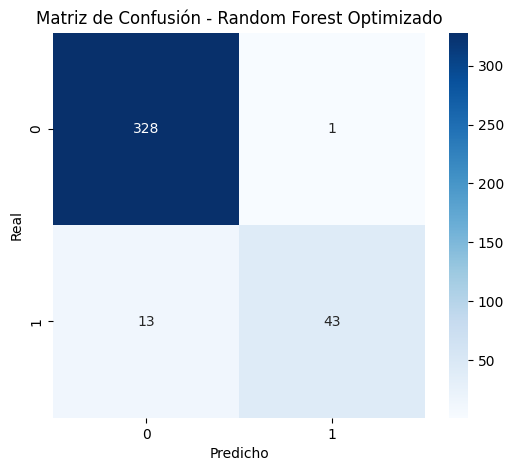

[[328   1]
 [ 13  43]]


<Figure size 600x600 with 0 Axes>

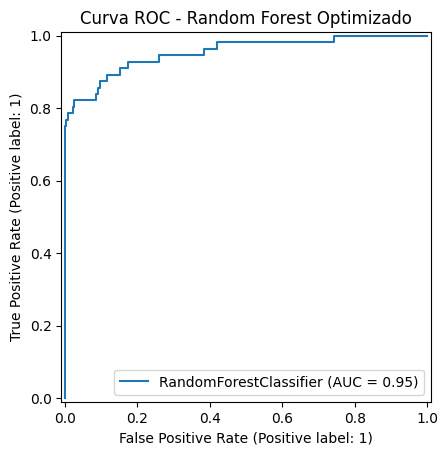

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 1. Definir el modelo base
rf_base = RandomForestClassifier(random_state=42)

# 2. Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# 3. Definir la validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Configurar el GridSearchCV optimizando el recall
grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# 5. Ejecutar GridSearch en los datos balanceados
grid_search_rf.fit(X_train_sm, y_train_sm)

# 6. Obtener el mejor modelo
rf_best = grid_search_rf.best_estimator_

# 7. Predecir sobre el conjunto de prueba real (no balanceado)
y_pred = rf_best.predict(X_test)
y_proba = rf_best.predict_proba(X_test)[:, 1]

# 8. Reporte de evaluación
print("Mejores hiperparámetros encontrados:", grid_search_rf.best_params_)
print("\nReporte de clasificación:")
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

# Calcular la media geométrica
g_mean = geometric_mean_score(y_test, y_pred)
print(f"Media Geométrica: {g_mean:.4f}")


# 9. Matriz de confusión
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Random Forest Optimizado")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()
print(confusion_matrix(y_test, y_pred))

# 10. Curva ROC
plt.figure(figsize=(6, 6))
RocCurveDisplay.from_estimator(rf_best, X_test, y_test)
plt.title("Curva ROC - Random Forest Optimizado")
plt.show()

# XGBoost

In [12]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Dividir los datos
X = df.drop(columns=["RIESGO_DESERCION"])
y = df["RIESGO_DESERCION"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Crear el modelo base de XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,        # Número total de árboles
    max_depth=3,             # Profundidad máxima de los árboles (controla overfitting)
    learning_rate=0.1,       # Tasa de aprendizaje
    subsample=1,             # Fracción de muestras usadas por árbol (1 = usar todas)
    colsample_bytree=1,      # Fracción de características usadas por árbol (1 = usar todas)
    objective="binary:logistic",  # Clasificación binaria
    random_state=42,         # Reproducibilidad
    use_label_encoder=False, # Evita advertencia innecesaria
    eval_metric="logloss"    # Métrica de evaluación (puede cambiarse)
)

# Entrenar
xgb_model.fit(X_train, y_train)


c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:10:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

### Reporte de métricas de desempeño

Matriz de Confusión:
 [[328   1]
 [ 13  43]]
Media Geométrica: 0.8749


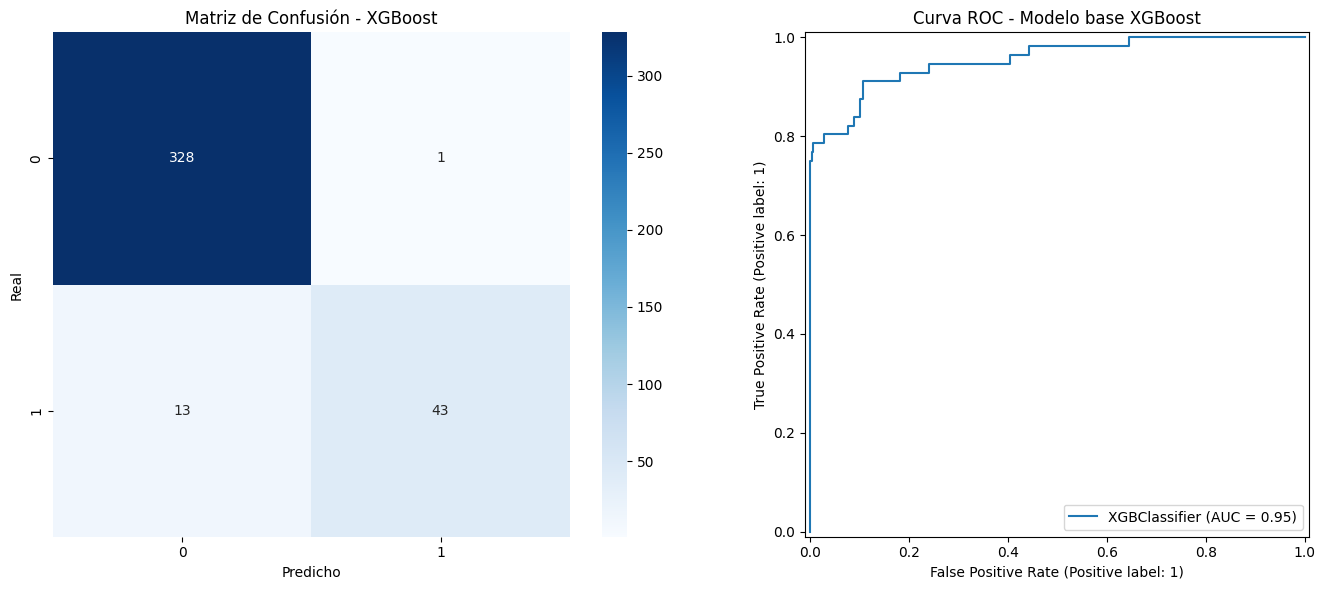

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       329
           1       0.98      0.77      0.86        56

    accuracy                           0.96       385
   macro avg       0.97      0.88      0.92       385
weighted avg       0.96      0.96      0.96       385

AUC: 0.954841511072514


In [37]:
# Predicciones y métricas
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Gráfico de la matriz de confusión

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:\n", conf_matrix)

# Calcular la media geométrica
g_mean = geometric_mean_score(y_test, y_pred)
print(f"Media Geométrica: {g_mean:.4f}")

# Crear figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Matriz de Confusión
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de Confusión - XGBoost")
axes[0].set_xlabel("Predicho")
axes[0].set_ylabel("Real")

# Subplot 2: Curva ROC
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, ax=axes[1])
axes[1].set_title("Curva ROC - Modelo base XGBoost")

# Ajustar diseño
plt.tight_layout()
plt.show()


print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_prob))




### Visualizar el primer árbol del modelo XGBoost

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


Text(0.5, 1.0, 'Primer árbol del modelo XGBoost')

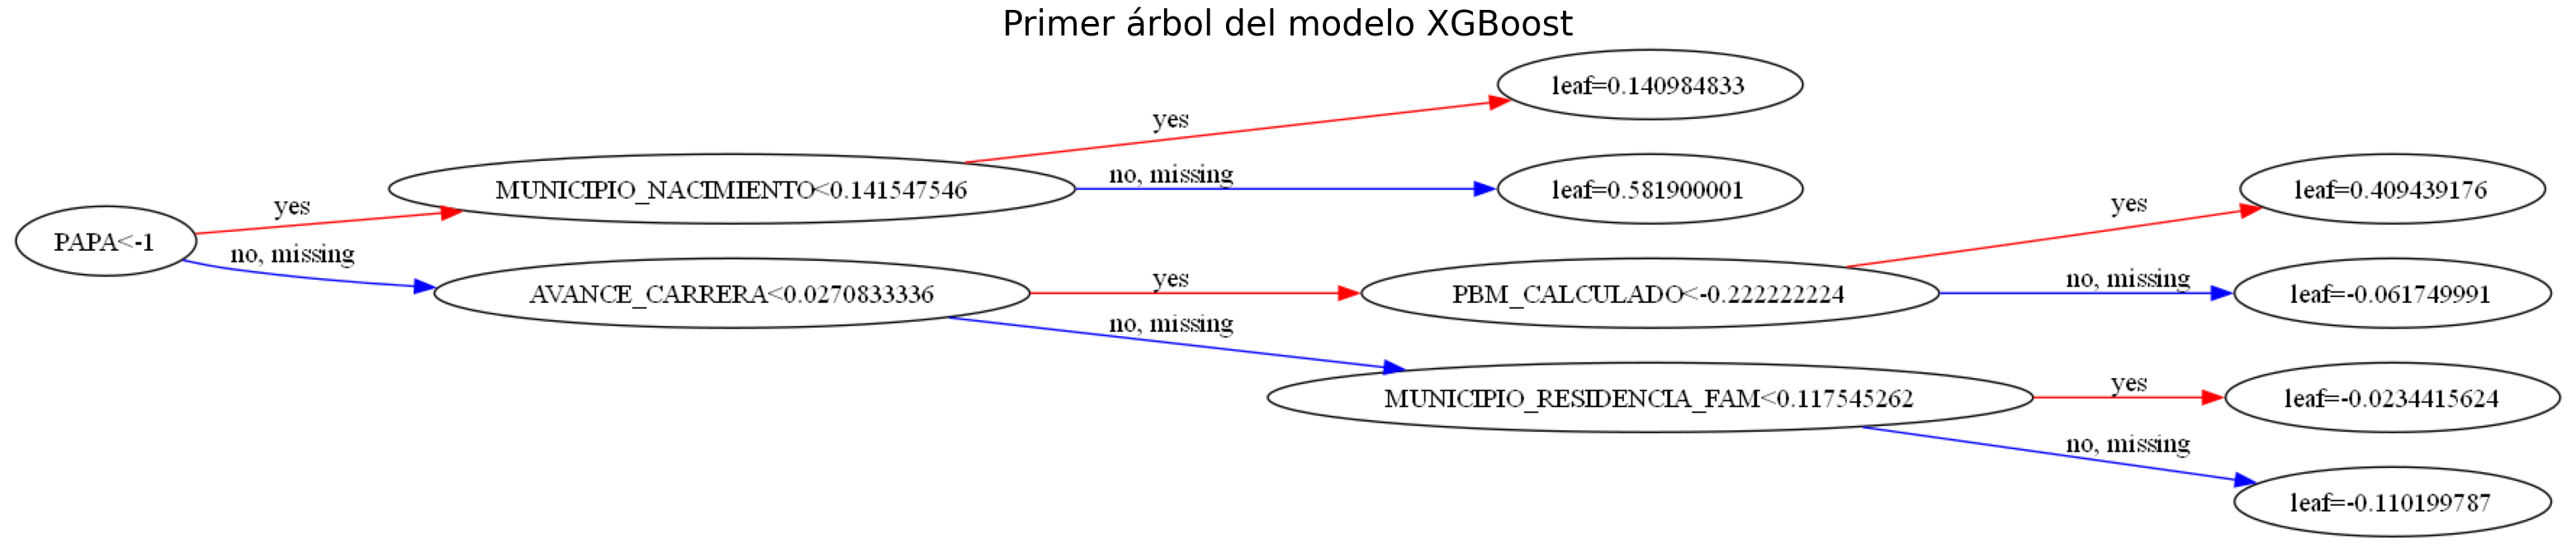

In [14]:
# Visualización del primer árbol
fig, ax = plt.subplots(figsize=(40, 20))  # aumenta tamaño
xgb.plot_tree(xgb_model, num_trees=0, rankdir='LR', ax=ax)
plt.title("Primer árbol del modelo XGBoost", fontsize=30)

### SHAP

In [15]:
import shap

# Crear el explicador con el modelo entrenado y los datos
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Opcional: verificar dimensión
print("SHAP values shape:", np.array(shap_values).shape)


SHAP values shape: (385, 27)


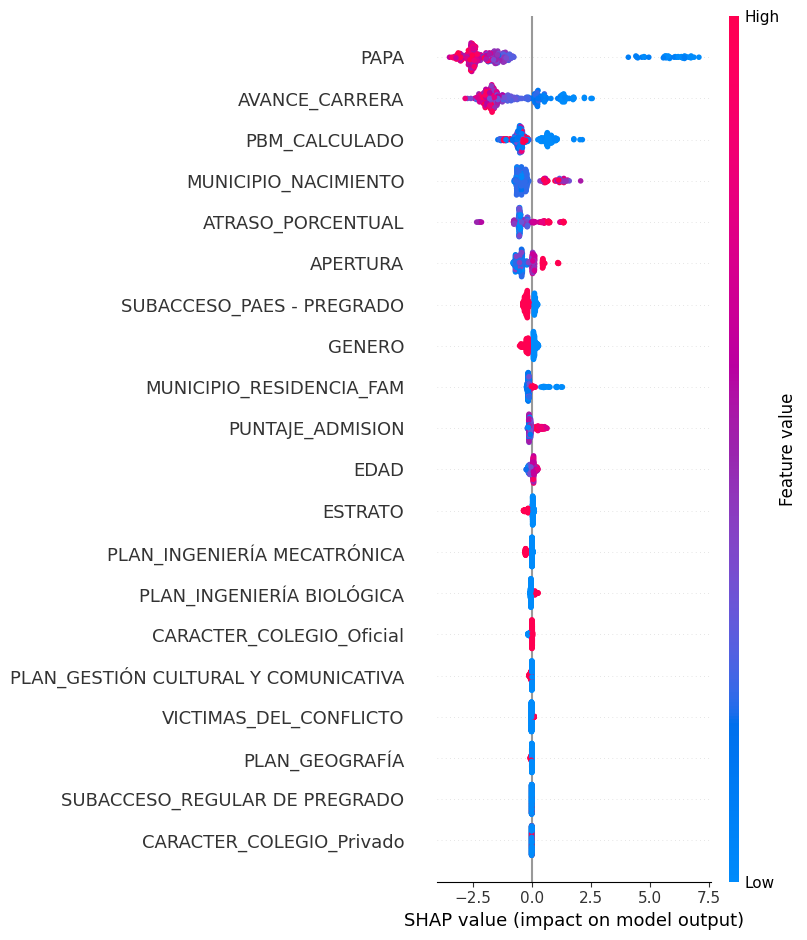

In [16]:
# Gráfico beeswarm para analizar impacto y dirección
shap.summary_plot(shap_values, X_test)


In [17]:
# Índice de la instancia a explicar (puedes cambiar el 0 por otro)
i = 1

# Gráfico tipo force (explicación local)
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i], matplotlib=True)


## XGBoost optimizado con GridSearch

In [38]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 1. Definir el modelo base
xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 2. Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [20, 50, 100, 150],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2, 0.4],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}


# 3. Definir la validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Configurar el GridSearchCV optimizando el *recall*
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='recall',  # Porque te interesa maximizar la detección de casos de riesgo (clase 1)
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# 5. Ejecutar GridSearch en los datos balanceados
grid_search.fit(X_train_sm, y_train_sm)

# 6. Obtener el mejor modelo
xgb_best = grid_search.best_estimator_

# 7. Predecir sobre el conjunto de prueba real (no balanceado)
y_pred = xgb_best.predict(X_test)
y_proba = xgb_best.predict_proba(X_test)[:, 1]


Fitting 5 folds for each of 576 candidates, totalling 2880 fits


c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:39:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [19]:
xgb_best

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

Mejores hiperparámetros encontrados: {'colsample_bytree': 1.0, 'learning_rate': 0.4, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       329
           1       0.90      0.80      0.85        56

    accuracy                           0.96       385
   macro avg       0.93      0.89      0.91       385
weighted avg       0.96      0.96      0.96       385

AUC: 0.9426834563612679
Media Geométrica: 0.8896


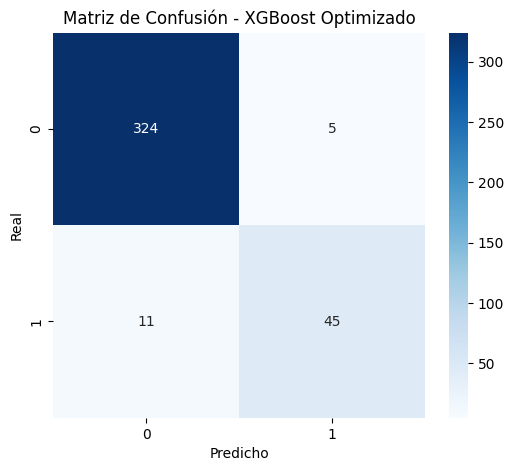

<Figure size 600x600 with 0 Axes>

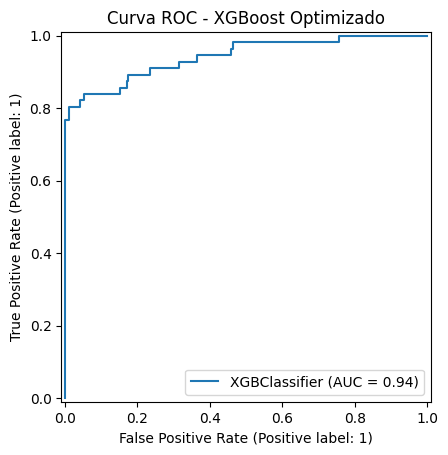

In [39]:
# 8. Reportes de evaluación
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

# Calcular la media geométrica
g_mean = geometric_mean_score(y_test, y_pred)
print(f"Media Geométrica: {g_mean:.4f}")

# 9. Matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - XGBoost Optimizado")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# 10. Curva ROC
plt.figure(figsize=(6, 6))
RocCurveDisplay.from_estimator(xgb_best, X_test, y_test)
plt.title("Curva ROC - XGBoost Optimizado")
plt.show()

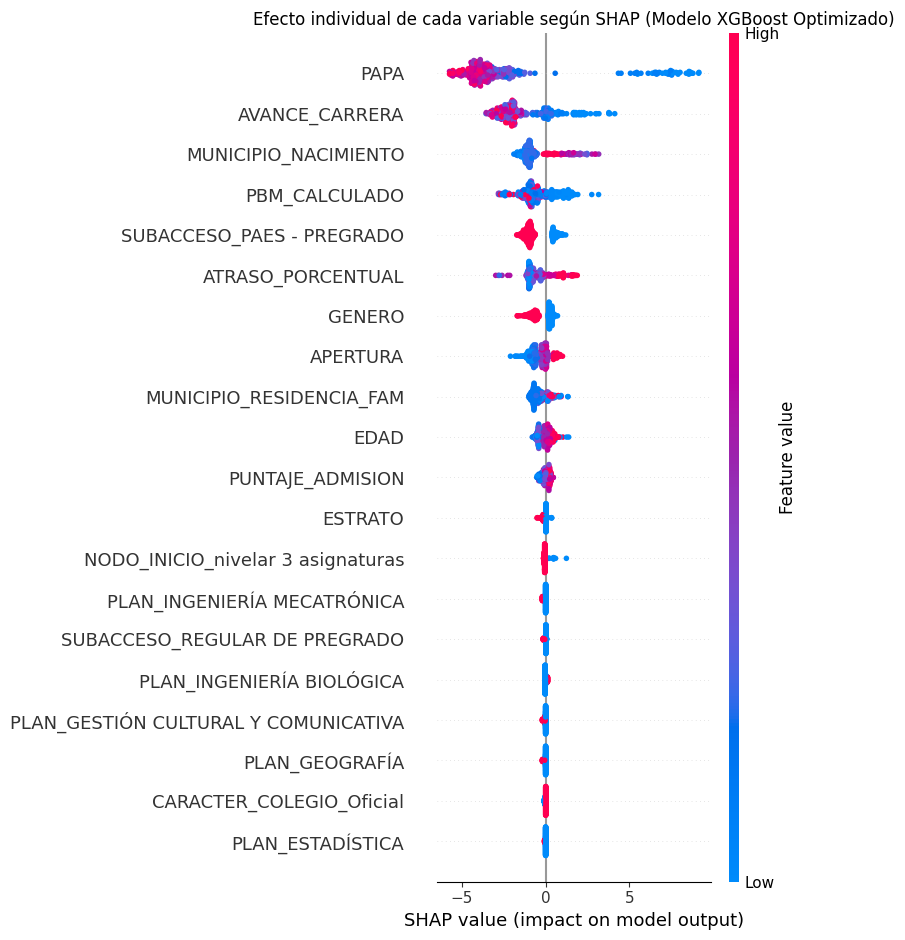

In [21]:
import shap
import matplotlib.pyplot as plt


# 1. Crear el objeto explainer con el modelo final
explainer = shap.Explainer(xgb_best)

# 2. Calcular valores SHAP en el conjunto de test
shap_values = explainer(X_test)

# 3. Gráfico resumen SHAP en forma de barras
# plt.title("Importancia Global de las Variables según SHAP (Modelo XGBoost Optimizado)")
# shap.summary_plot(shap_values, X_test, plot_type="bar")

# plt.title("efecto individual de cada valor de una variable sobre la predicción según SHAP (Modelo XGBoost Optimizado)")
plt.title("Efecto individual de cada variable según SHAP (Modelo XGBoost Optimizado)")
# 4. Gráfico tipo swarm (más detallado)
shap.summary_plot(shap_values, X_test)


In [ ]:
# Para XGBoost con shap.Explainer, shap_values.values es el array de valores SHAP
importancias = np.abs(shap_values.values).mean(axis=0)
nombres_vars = X_test.columns

df_importancia = pd.DataFrame({
    "Variable": nombres_vars,
    "Importancia_SHAP": importancias
}).sort_values(by="Importancia_SHAP", ascending=False)

print(df_importancia.head(10))  # Top 10 variables más importantes

                     Variable  Importancia_SHAP
4                        PAPA          4.001338
0              AVANCE_CARRERA          1.849733
7        MUNICIPIO_NACIMIENTO          1.092913
5               PBM_CALCULADO          0.924291
20  SUBACCESO_PAES - PREGRADO          0.910777
13          ATRASO_PORCENTUAL          0.801070
2                      GENERO          0.499709
1                    APERTURA          0.489804
11   MUNICIPIO_RESIDENCIA_FAM          0.468814
3                        EDAD          0.283177


# SVM

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94       329
           1       0.65      0.70      0.67        56

    accuracy                           0.90       385
   macro avg       0.80      0.82      0.81       385
weighted avg       0.90      0.90      0.90       385

Matriz de Confusión:
 [[308  21]
 [ 17  39]]
AUC: 0.9311767260095527
Media Geométrica: 0.8075


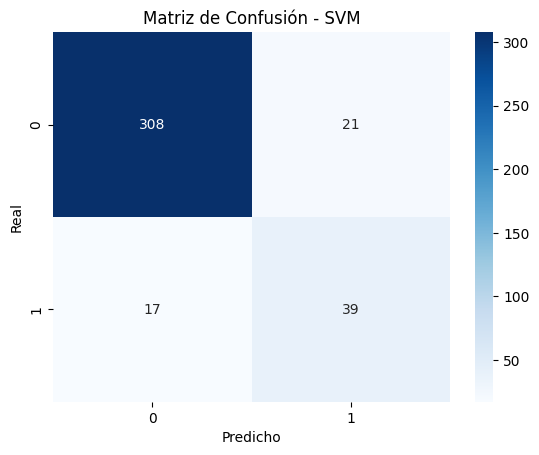

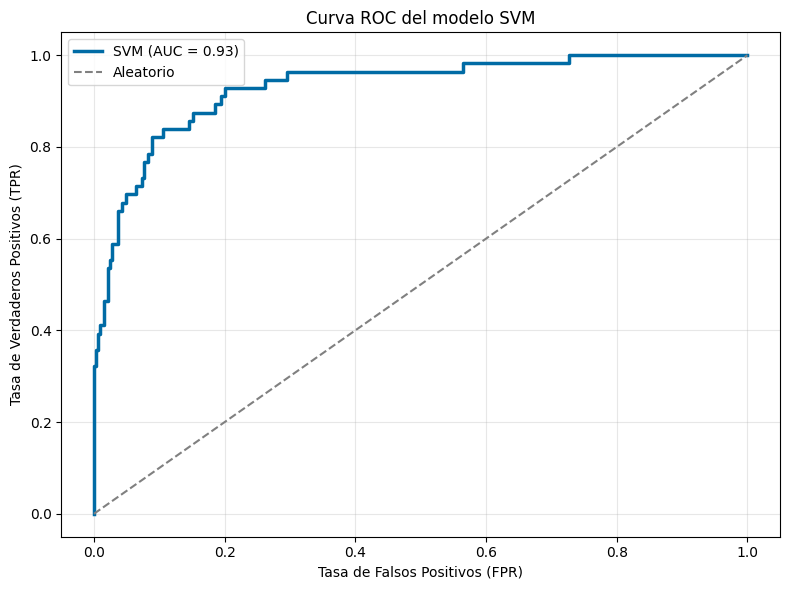

In [40]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.metrics import roc_curve

# Entrenar modelo base SVM con datos balanceados (SMOTE)
svm_model = SVC(
    kernel='rbf',            # kernel radial base (no lineal)
    C=1.0,                   # parámetro de penalización por error
    gamma='scale',           # coeficiente para el kernel RBF (autoajustado)
    probability=True,        # para poder calcular probabilidades y curva ROC
    random_state=42
)

# Entrenar
svm_model.fit(X_train_sm, y_train_sm)

# Predicciones
y_pred = svm_model.predict(X_test)
y_proba = svm_model.predict_proba(X_test)[:, 1]  # Para ROC AUC

# Reporte
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

# Calcular la media geométrica
g_mean = geometric_mean_score(y_test, y_pred)
print(f"Media Geométrica: {g_mean:.4f}")

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - SVM")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Gráfica de curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc_score(y_test, y_proba):.2f})", color="#006BA5", linewidth=2.5)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatorio')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC del modelo SVM")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### SVM optimizado con grid search

In [41]:
# 2. Definir modelo base
svm_model = SVC(probability=True, random_state=42)

# # 3. Definir espacio de búsqueda de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10, 100],                 # Regularización
    'kernel': ['poly','rbf', 'linear',  ],    # Tipos de kernel
    'gamma': ['scale', 'auto'],             # Coeficiente del kernel (para rbf/poly)
    'degree': [2, 3, 4, 5]
}


# 4. Configurar búsqueda en grilla
grid_search_svm = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    scoring='recall',         # maximizamos el recall (importante para detectar deserción)
    cv=5,
    verbose=1,
    n_jobs=-1
)

# 5. Entrenar
grid_search_svm.fit(X_train_sm, y_train_sm)

# 6. Evaluar en el conjunto de prueba
best_svm = grid_search_svm.best_estimator_
y_pred = best_svm.predict(X_test)
y_proba = best_svm.predict_proba(X_test)[:, 1]



Fitting 5 folds for each of 96 candidates, totalling 480 fits


Mejores hiperparámetros: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       329
           1       0.69      0.66      0.67        56

    accuracy                           0.91       385
   macro avg       0.81      0.80      0.81       385
weighted avg       0.91      0.91      0.91       385

AUC: 0.9113113330438558
Matriz de Confusión:
 [[312  17]
 [ 19  37]]
Media Geométrica: 0.7916


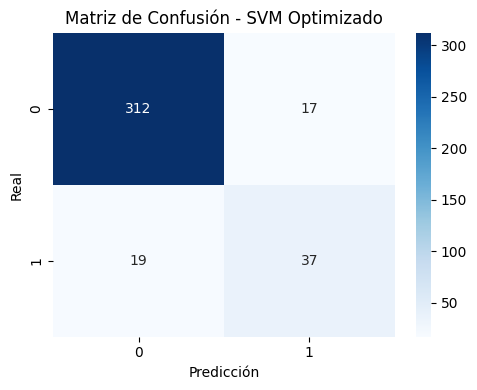

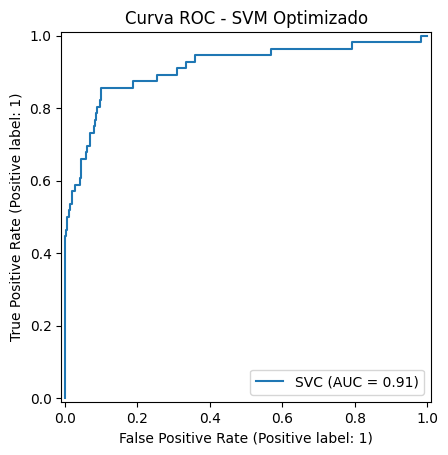

In [42]:
# 7. Reporte de métricas
print("Mejores hiperparámetros:", grid_search_svm.best_params_)
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred))

# Calcular la media geométrica
g_mean = geometric_mean_score(y_test, y_pred)
print(f"Media Geométrica: {g_mean:.4f}")

# 8. Matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - SVM Optimizado")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 9. Curva ROC
RocCurveDisplay.from_estimator(best_svm, X_test, y_test)
plt.title("Curva ROC - SVM Optimizado")
plt.show()